## Fitting psychometric performance 

The goal of this notebook is to familiarize you with how to do some basic fitting of psychometric curves.


Check out the [Palamedes toolbox](https://www.palamedestoolbox.org/) that is widely used to fit psychometric curves in matlab and accompaning book: *Kingdom, F.A.A. & Prins, N. (2016) Psychophysics: A Practical Introduction, 2nd edition. Academic Press: an imprint of Elsevier, London ISBN-13: 978-0124071568* - [this chapter](https://www.sciencedirect.com/science/article/pii/B9780124071568000049#s0020)
 

In [1]:
import numpy as np    # math and array handling 
import pandas as pd   # some functions to load data and handle tables
import pylab as plt   # plotting stuff
# import a function to compute the proportions from the behavior
import sys; sys.path.append('..')  # this is not needed if you install the module
from fit_psychometric import compute_proportions

# Note that if you want the plots to be interactive change the %matplotlib option
# the option can be 
#     qt - to use plots in a separate window,
#     notebook to use interactive "widgets" or
#     inline - not interactive
#     widget - interactive on vscode
%matplotlib inline

# load the example dataset
session_data = pd.read_hdf("../example/tutorial1_JC089_20221118.dataset.hdf5")


### Fit the psychometric curve to trial-to-trial data

Psychometric curves are used to model the behavioral performance of mice in decision-making tasks.

There are many ways to fit psychometric curves. Two main ones stand out: 
 1. Fitting to the average psychometric points - **bad** - this does not take into account that there are different number of trials per condition
 2. Fitting to trial points - weights each trial, this will be the best approximation to models the performance.

In summary: fitting to the average points is not good, because all intensities count the same for the fit but there are some have different number of trials.

We will fit it with a **cumulative gaussian**, by minimizing the log likelihood error of all trials. 
A good course on this is here (where they use the **weibull**) http://courses.washington.edu/matlab1/Lesson_5.html#6


#### Defining the function that we will use to model the behavior

The first step is defining the curve that we will use to fit the psychometric behavior.
There are many options depending on the behavior performance and the scientific question at hand.
Two of the most common are the `Cumulative gaussian`, the `Weibull` or the `Logistic` function; these are quite similar.

Learn more about how the parameters of different models relate to each other [here](https://www.sciencedirect.com/science/article/pii/B9780124071568000049#s0020) or in ...

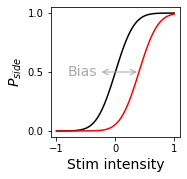

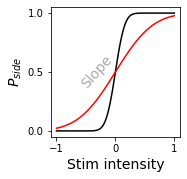

In [2]:
def cumulative_gaussian(alpha,beta,gamma,lmbda, X):
    '''
    Evaluate the cumulative gaussian psychometric function.
       alpha is the bias (left or right)
       beta is the slope
       gamma is the left handside offset
       lmbda is the right handside offset
      
    Adapted from the Palamedes toolbox 
    Joao Couto - Jan 2022    
    '''
        
    from scipy.special import erfc # import the complementary error function 
    return  gamma + (1 - gamma - lmbda)*0.5*erfc(-beta*(X-alpha)/np.sqrt(2))    

X = np.linspace(-1,1,100)
fig = plt.figure(figsize=[3,3])
fig.add_axes([.3,.3,.6,.6])
# changing the bias parameter
plt.plot(X,cumulative_gaussian(0,4,0,0,X),'k',alpha=1)
plt.plot(X,cumulative_gaussian(0.4,4,0,0,X),'r')
plt.annotate('Bias', xy=(0.4, 0.5), xycoords='data',
            xytext=(-.3, .5), textcoords='data',
            va='center', ha='right',fontsize=14,color='darkgray',
            arrowprops=dict(arrowstyle="<->",color='darkgray'))
plt.xlabel('Stim intensity',fontsize=14)
plt.ylabel('$P_{side}$',fontsize=14)
plt.yticks([1,.5,0])
plt.xticks([-1,0,1]);

fig = plt.figure(figsize=[3,3])
fig.add_axes([.3,.3,.6,.6])
# changing the slope parameter
plt.plot(X,cumulative_gaussian(0,8,0,0,X),'k',alpha=1)
plt.plot(X,cumulative_gaussian(0,2,0,0,X),'r')
plt.text(0,0.5,'Slope',rotation=48,
            va='center', ha='right',fontsize=14,color='darkgray')
plt.xlabel('Stim intensity',fontsize=14)
plt.ylabel('$P_{side}$',fontsize=14)
plt.yticks([1,.5,0])
plt.xticks([-1,0,1]);



Can we guess an approximation to the behavior data?

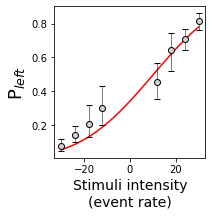

In [3]:
sel = session_data[session_data.response != 0] # select only trials where the subject responded
responded_left = np.array(sel.response == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)
stim_intensities = sel.stim_intensity

intensities, p_left, ci_left, _, _ = compute_proportions(stim_values=stim_intensities, response_values=responded_left)

# plot
fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.25,0.25,0.7,0.7])

# generate a curve with GUESSED parameters
nx = np.linspace(np.min(intensities),np.max(intensities),100)
ax.plot(nx,cumulative_gaussian(10,0.04,0,0.01,nx),'r')

# plot the observed data and confidence intervals
for i,e in zip(intensities,ci_left):  # plot the confidence intervals
    ax.plot(i*np.array([1,1]),e,'_-',lw=0.5,color = 'black')
ax.plot(intensities,p_left,'ko',markerfacecolor = 'lightgray',markersize = 6)

ax.set_ylabel('P$_{left}$',fontsize = 18)  # set the y-axis label with latex nomenclature
ax.set_xlabel('Stimuli intensity\n(event rate)', fontsize = 14); # set the x-axis label

To actually fit the curve we will need a metric of how well the model fits to the data. 
For that we will use the negative  **log likelihood error** - which is just the log of the likelihood $ \prod( {p}^{r}.(1-{p})^(1-r))$ with $p$ the predicted values by the model/equation and $r$ the actual response of the subject. Because the likelihood would result in very small values that would be hard to handle, we use the log likelihood.


In [4]:
def neg_log_likelihood_error(func, parameters, X, Y):
    '''
    Compute the log likelihood for a function
    
    'func' is the (psychometric) function 
    'parameters' are the input parameters to 'func'
    'Y' is the binary response (correct = 1; incorrect=0)
    '''

    pX = func(*parameters, X)*0.99 + 0.005  # the predicted performance for X from the PMF
    # small value added to prevent error in log(0)
    val = np.nansum(Y*np.log(pX) + (1-Y)*np.log(1-pX))
    return -1*val # we invert it, because we want to use the minimize function later on

Lets see how log likelihood error evolves for our example dataset for a defined range of bias and slopes terms.

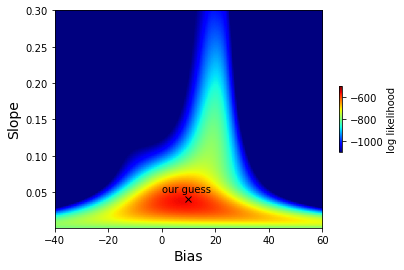

In [5]:
slopes = np.linspace(0.001,0.3,100)
biases = np.linspace(-40,60,100)
lle = np.zeros([len(slopes),len(biases)])

S = stim_intensities.astype(float)
R = responded_left.astype(float)

for i,b in enumerate(slopes):
    for j,a in enumerate(biases):
        lle[i,j] = -1*neg_log_likelihood_error(cumulative_gaussian, [a,b,0,0], S,R)


plt.figure()
plt.imshow(lle,cmap='jet',clim = [-500,-1000],aspect='auto',origin='lower',
            extent=[biases[0],biases[-1],slopes[0],slopes[-1]])
plt.xlabel('Bias',fontsize=14)
plt.ylabel('Slope',fontsize=14)
plt.colorbar(label='log likelihood',shrink=0.3);
plt.plot(10,0.04,'kx')
plt.text(0,0.05,'our guess',color='k');

Lets now use an optimization function to find the best guess, we will use scipy's `minimize` function. There are many different implementations of these, we will use the `Nelder-Mead` method.

All minimization algorithms are sensitive to the initial guess so we will provide an educated guess for these.

In [6]:
from scipy.optimize import minimize


sel = session_data[session_data.response != 0] # select only trials where the subject responded
responded_left = np.array(sel.response == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)
stim_intensities = sel.stim_intensity
# we use the proportions to the initial guess
intensities, p_left, ci_left, _, _ = compute_proportions(stim_values=stim_intensities, response_values=responded_left)

# x0 is the initial guess for the fit, it is an important parameter
# here we chose a bad slope and bias values, you can use the proportions to estimate better values which will reduce the time it takes to fit.
x0 = [0.,0.001,p_left[0],1 - p_left[-1]]
# limit the boundaries so the algorithm does not start using values that are not plausible
bounds = [(intensities[0],intensities[-1]),(0.00001,10),(0,0.7),(0,.7)]

# format the function so minimize can use it
func = lambda pars: neg_log_likelihood_error(cumulative_gaussian, pars, stim_intensities.astype(float),responded_left.astype(float))
# run the minimization algorithm
res = minimize(func, x0, options = dict(maxiter = 500*len(x0),adaptive=True),
               bounds = bounds, method='Nelder-Mead') # method = 'L-BFGS-B',
# show the results
print('Estimated parameters: bias {0:2.2f} slope {1:2.2f} left offset {2:2.2f} right offset {3:2.2f}'.format(*res.x))

Estimated parameters: bias 7.61 slope 0.04 left offset 0.00 right offset 0.00


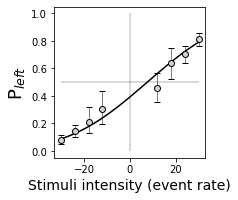

In [8]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_axes([0.2,0.2,0.7,0.7])
ax.vlines(0,0,1,color = 'k',lw = 0.3) # plot a vertical line as reference at zero
ax.hlines(0.5,np.min(intensities),np.max(intensities),color = 'k',lw = 0.3) # plot an horizontal line as reference for chance performance

# plot the fit
nx = np.linspace(np.min(intensities),np.max(intensities),100)
ax.plot(nx,cumulative_gaussian(*res.x,nx),'k')

# plot the observed data and confidence intervals
for i,e in zip(intensities,ci_left):  # plot the confidence intervals
    ax.plot(i*np.array([1,1]),e,'_-',lw=0.5,color = 'black')
ax.plot(intensities,p_left,'ko',markerfacecolor = 'lightgray',markersize = 6)

ax.set_ylabel('P$_{left}$',fontsize = 18)  # set the y-axis label with latex nomenclature
ax.set_xlabel('Stimuli intensity (event rate)', fontsize = 14); # set the x-axis label
